In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [3]:
# Loading data
pv_data = pd.read_excel("new_PVs.xlsx")
intraday_2024 = pd.read_csv("json_2024.csv")
intraday_2023 = pd.read_csv("json_2023.csv")
production_data = pd.read_excel("PV_production.xlsx")

In [4]:
print(intraday_2024.isna().sum())
print(intraday_2023.isna().sum())

Unnamed: 0    0
date          0
price         0
dtype: int64
Unnamed: 0    0
date          0
price         0
dtype: int64


In [5]:
intraday_2024['date'] = pd.to_datetime(intraday_2024['date'], utc=True)
intraday_2024['date'] = intraday_2024['date'].dt.tz_convert('CET')
intraday_2024['date'] = intraday_2024['date'].dt.tz_localize(None)
intraday_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  8784 non-null   int64         
 1   date        8784 non-null   datetime64[ns]
 2   price       8784 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 206.0 KB


In [6]:
intraday_2023['date'] = pd.to_datetime(intraday_2023['date'], utc=True)
intraday_2023['date'] = intraday_2023['date'].dt.tz_convert('CET')
intraday_2023['date'] = intraday_2023['date'].dt.tz_localize(None)
intraday_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  8760 non-null   int64         
 1   date        8760 non-null   datetime64[ns]
 2   price       8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 205.4 KB


In [7]:
intraday_2024['Day_of_Week'] = intraday_2024['date'].dt.day_name()
intraday_2024['Hour'] = intraday_2024['date'].dt.hour

intraday_2023['Day_of_Week'] = intraday_2023['date'].dt.day_name()
intraday_2023['Hour'] = intraday_2023['date'].dt.hour

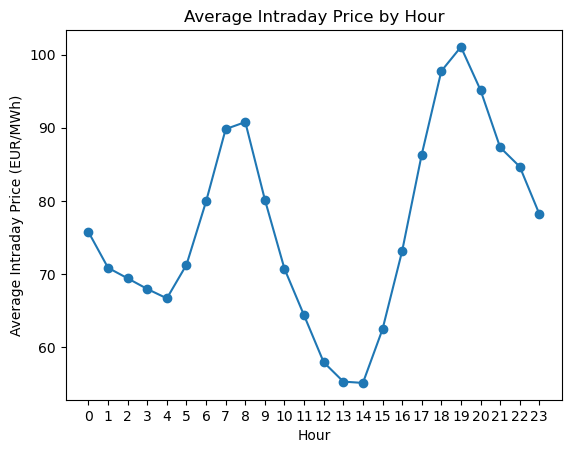

In [8]:
# Calculating average price grouped by hour
intra_grouped_by_hour = intraday_2024.groupby('Hour')['price'].mean().reset_index()

plt.plot(intra_grouped_by_hour['Hour'], intra_grouped_by_hour['price'], marker='o')
plt.title('Average Intraday Price by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Intraday Price (EUR/MWh)')
plt.xticks(range(0, 24))  
plt.show()

In [9]:
# Setting up parameters 
storage_capacity = 500  # kWh
charge_rate = 250  # kWh, equivalent to 0.5C
discharge_rate = 500  # kWh, equivalent to 1C
usable_capacity_rate = 0.7 # As per our discussion
efficiency = 0.9

In [10]:
# Setting 'Date' as index for time series
intraday_2024['date_ref'] = intraday_2024['date']
intraday_2023['date_ref'] = intraday_2023['date']

# Converting prices from EUR/MWh to EUR/kWh
intraday_2024['intraday_kWh'] = intraday_2024['price'] / 1000
intraday_2023['intraday_kWh'] = intraday_2023['price'] / 1000

In [11]:
intraday_2024.set_index('date', inplace=True)
intraday_2023.set_index('date', inplace=True)

### Calculating potential profit based on the 2023 and 2024 data
The following scenarios have been tested.
* Scenario 1: Buy at 0 or below and sell from 19h (typically the highest price)
* Scenario 2: Buy at two low peaks and sell at two high peaks
* Scenario 3: Buy at two low peaks and sell at two high peaks except for Sunday transactions that are to be sold on Monday
* Scenario 4: Buy at bottom 40% prices and sell at top 40% prices
* Scenario 5: Buy at bottom 25% prices and sell at top 25% prices
* Scenario 6: Buy at bottom 15% prices and sell at top 15% prices
* Scenario 7: Buy at 13-15h and sell at 19-20h

In [12]:
# Setting up parameters 
storage_capacity = 500  # kWh
charge_rate = 250  # kWh, equivalent to 0.5C
discharge_rate = 500  # kWh, equivalent to 1C
usable_capacity_rate = 0.7 # As per our discussion
efficiency = 0.9

#### Scenario 1: Buy at 0 or below and sell from 19h (typically the highest price)

In [13]:
def simulate_scenario_1(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate

    total_energy_bought = 0
    total_energy_sold = 0

    # Adjust for 15-minute intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else: 
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    for timestamp, price in price_data[price_column].items():
        # Buy when price is 0 or below
        if price <= 0 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price  
            state_of_charge += energy_to_buy
            total_energy_bought += energy_to_buy  # Track total energy bought

        # Sell from 19h
        elif 19 <= timestamp.hour and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track total energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

#### Scenario 2: Buy at two low peaks and sell at two high peaks 

In [14]:
def simulate_scenario_2(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate

    total_energy_bought = 0
    total_energy_sold = 0

    # Adjust for 15-minute intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    for timestamp, price in price_data[price_column].items():
        hour = timestamp.hour

        # Buy at 3-5 AM or 1-3 PM
        if (3 <= hour <= 5 or 13 <= hour <= 15) and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy
            total_energy_bought += energy_to_buy  # Track total energy bought

        # Sell at 8-9 AM or 19-20 PM
        elif (8 <= hour <= 9 or 19 <= hour <= 20) and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track total energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

#### Scenario 3: Buy at two low peaks and sell at two high peaks except for Sunday transactions that are to sold on Monday

In [15]:
def simulate_scenario_3(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    last_charge_day = None  # Tracking days
    
    total_energy_bought = 0
    total_energy_sold = 0
    
    # Adjust for time intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate
    
    for timestamp, price in price_data[price_column].items():
        hour = timestamp.hour
        day_of_week = timestamp.weekday()  # 0 = Monday, 6 = Sunday
        
        # Sunday 
        if day_of_week == 6:
            if (3 <= hour <= 5 or 13 <= hour <= 15) and state_of_charge < usable_capacity:
                energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
                cost += energy_to_buy * price
                state_of_charge += energy_to_buy 
                total_energy_bought += energy_to_buy  # Track total energy bought
                last_charge_day = 6  # Mark Sunday
            
            elif (8 <= hour <= 9) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
                total_energy_sold += energy_to_sell * efficiency  # Track total energy sold
        
        # Monday
        elif day_of_week == 0:
            if last_charge_day == 6 and (7 <= hour <= 9) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
                total_energy_sold += energy_to_sell * efficiency  # Track total energy sold
                last_charge_day = None  # Reset tracking
                
            elif (13 <= hour <= 15) and state_of_charge < usable_capacity:
                energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
                cost += energy_to_buy * price
                state_of_charge += energy_to_buy 
                total_energy_bought += energy_to_buy  # Track total energy bought
                
            elif (19 <= hour <= 20) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
                total_energy_sold += energy_to_sell * efficiency  # Track total energy sold
        
        # Tuesday to Saturday 
        elif day_of_week in [1, 2, 3, 4, 5]:
            if (3 <= hour <= 5 or 13 <= hour <= 15) and state_of_charge < usable_capacity:
                energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
                cost += energy_to_buy * price
                state_of_charge += energy_to_buy 
                total_energy_bought += energy_to_buy  # Track total energy bought
                
            elif (8 <= hour <= 9 or 19 <= hour <= 20) and state_of_charge > 0:
                energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
                revenue = energy_to_sell * efficiency * price
                state_of_charge -= energy_to_sell
                profit += revenue
                total_energy_sold += energy_to_sell * efficiency  # Track total energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

#### Scenario 4: Buy at bottom 40% prices and sell at top 40% prices

In [16]:
def simulate_scenario_4(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate
    last_charge_time = None

    total_energy_bought = 0
    total_energy_sold = 0

    # Adjust for time intervals 
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate 

    # 40% and 60% thresholds for prices
    low_price_threshold_s4 = price_data[price_column].quantile(0.4)
    high_price_threshold_s4 = price_data[price_column].quantile(0.6)

    for timestamp, price in price_data[price_column].items():
        if 19 <= timestamp.hour and state_of_charge > 0:
            # Sell energy if price is high (above 60th percentile) and storage has energy
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

        elif price <= low_price_threshold_s4 and state_of_charge < usable_capacity:
            # Buy energy when price is low (below 40th percentile) and storage is not full
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy 
            total_energy_bought += energy_to_buy  # Track energy bought
            
        elif price >= high_price_threshold_s4 and state_of_charge > 0:
            # Sell energy when price is high (above 60th percentile) and storage has energy
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

#### Scenario 5: Buy at bottom 25% prices and sell at top 25% prices

In [17]:
def simulate_scenario_5(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate

    total_energy_bought = 0
    total_energy_sold = 0

    # Adjust for time intervals 
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    # 25% and 75% thresholds for prices
    low_price_threshold_s5 = price_data[price_column].quantile(0.25)
    high_price_threshold_s5 = price_data[price_column].quantile(0.75)

    for timestamp, price in price_data[price_column].items():
        if 19 <= timestamp.hour and state_of_charge > 0:
            # Sell energy if price is high (above 75th percentile) and storage has energy
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

        elif price <= low_price_threshold_s5 and state_of_charge < usable_capacity:
            # Buy energy when price is low (below 25th percentile) and storage is not full
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy 
            total_energy_bought += energy_to_buy  # Track energy bought
            
        elif price >= high_price_threshold_s5 and state_of_charge > 0:
            # Sell energy when price is high (above 75th percentile) and storage has energy
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

#### Scenario 6: Buy at bottom 15% prices and sell at top 15% prices

In [18]:
def simulate_scenario_6(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate

    total_energy_bought = 0
    total_energy_sold = 0

    # Adjust for 15-minute intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    # 15% and 85% thresholds for prices
    low_price_threshold_s6 = price_data[price_column].quantile(0.15)
    high_price_threshold_s6 = price_data[price_column].quantile(0.85)

    for timestamp, price in price_data[price_column].items():
        if 19 <= timestamp.hour and state_of_charge > 0:
            # Sell energy when price is high (above 85th percentile) and storage has energy
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

        # Buy energy when price is low (below 15th percentile) and storage is not full
        elif price <= low_price_threshold_s6 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy
            total_energy_bought += energy_to_buy  # Track energy bought
            
        # Sell energy when price is high (above 85th percentile) and storage has energy
        elif price >= high_price_threshold_s6 and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

#### Scenario 7: Buy at 13-15h and sell at 19-20h

In [19]:
def simulate_scenario_7(price_data, price_column, storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'):
    state_of_charge = 0  # kWh
    profit = 0  # EUR
    cost = 0  # EUR
    usable_capacity = storage_capacity * usable_capacity_rate

    total_energy_bought = 0
    total_energy_sold = 0

    # Adjust for 15-minute intervals
    if time_interval == '15min':
        charge_energy_per_interval = charge_rate / 4  # Divide by 4 for 15-minute intervals
        discharge_energy_per_interval = discharge_rate / 4
    else:  
        charge_energy_per_interval = charge_rate
        discharge_energy_per_interval = discharge_rate

    for timestamp, price in price_data[price_column].items():
        hour = timestamp.hour

        # Buy at 1-3 PM when storage is not full
        if 13 <= hour <= 15 and state_of_charge < usable_capacity:
            energy_to_buy = min(charge_energy_per_interval, usable_capacity - state_of_charge)
            cost += energy_to_buy * price
            state_of_charge += energy_to_buy
            total_energy_bought += energy_to_buy  # Track energy bought

        # Sell at 19-20 PM when storage has energy
        elif 19 <= hour <= 20 and state_of_charge > 0:
            energy_to_sell = min(discharge_energy_per_interval, state_of_charge)
            revenue = energy_to_sell * efficiency * price
            state_of_charge -= energy_to_sell
            profit += revenue
            total_energy_sold += energy_to_sell * efficiency  # Track energy sold

    # Calculate the total full cycles
    total_energy = total_energy_bought + total_energy_sold * 10/9
    total_cycles = total_energy / (2 * storage_capacity)

    return {
        "profit": profit - cost,
        "total_energy_bought": total_energy_bought,
        "total_energy_sold": total_energy_sold,
        "total_cycles": total_cycles 
    }

### Results

In [25]:
# Simulating for 2023
intra_2023_results = {
    f"Scenario {i}": globals()[f"simulate_scenario_{i}"](
        intraday_2023, 'intraday_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'
    ) for i in range(1, 8)
}

# Simulating for 2024
intra_2024_results = {
    f"Scenario {i}": globals()[f"simulate_scenario_{i}"](
        intraday_2024, 'intraday_kWh', storage_capacity, charge_rate, discharge_rate, usable_capacity_rate, efficiency, time_interval='1h'
    ) for i in range(1, 8)
}

# Function to print formatted results
def print_results(year, results):
    print(f"\nResults for {year}")
    for scenario, data in results.items():
        total_cycles = (data['total_energy_bought'] + (data['total_energy_sold'] * 10 / 9)) / (2 * storage_capacity)
        print(f"{scenario}: Profit: {data['profit']:.2f} EUR, Energy Bought: {data['total_energy_bought']:.2f} kWh, Energy Sold: {data['total_energy_sold']:.2f} kWh, Total Cycles: {total_cycles:.2f}")

# Printing results for 2023 & 2024
print_results(2023, intra_2023_results)
print_results(2024, intra_2024_results)


Results for 2023
Scenario 1: Profit: 2389.27 EUR, Energy Bought: 23650.00 kWh, Energy Sold: 21285.00 kWh, Total Cycles: 47.30
Scenario 2: Profit: 7006.45 EUR, Energy Bought: 255500.00 kWh, Energy Sold: 229950.00 kWh, Total Cycles: 511.00
Scenario 3: Profit: 6445.50 EUR, Energy Bought: 237300.00 kWh, Energy Sold: 213255.00 kWh, Total Cycles: 474.25
Scenario 4: Profit: 3075.16 EUR, Energy Bought: 154400.00 kWh, Energy Sold: 138960.00 kWh, Total Cycles: 308.80
Scenario 5: Profit: 3385.28 EUR, Energy Bought: 98800.00 kWh, Energy Sold: 88920.00 kWh, Total Cycles: 197.60
Scenario 6: Profit: 3395.80 EUR, Energy Bought: 67000.00 kWh, Energy Sold: 60300.00 kWh, Total Cycles: 134.00
Scenario 7: Profit: 4244.55 EUR, Energy Bought: 127750.00 kWh, Energy Sold: 114975.00 kWh, Total Cycles: 255.50

Results for 2024
Scenario 1: Profit: 1813.81 EUR, Energy Bought: 24500.00 kWh, Energy Sold: 22050.00 kWh, Total Cycles: 49.00
Scenario 2: Profit: 6381.60 EUR, Energy Bought: 256200.00 kWh, Energy Sold: 23

#### Day Ahead results for comparison
Profit for Day Ahead 2023
* Scenario 1: 449.08 EUR
* Scenario 2: 6066.28 EUR
* Scenario 3: 5612.44 EUR
* Scenario 4: 1064.88 EUR
* Scenario 5: 1512.41 EUR
* Scenario 6: 1446.44 EUR

Profit for Day Ahead 2024
* Scenario 1: 1414.80 EUR
* Scenario 2: 5895.10 EUR
* Scenario 3: 5702.01 EUR
* Scenario 4: 899.00 EUR
* Scenario 5: 1507.29 EUR
* Scenario 6: 1958.61 EUR

In [21]:
price_data = pd.read_csv("prices.csv")

In [22]:
# Cleaning data
price_data['Date'] = pd.to_datetime(price_data['Date (GMT+1)'], format="%d.%m.%Y %H:%M")
price_data['Year'] = price_data['Date'].dt.year
price_data['Day Ahead Auction (CH)'] = pd.to_numeric(price_data['Day Ahead Auction (CH)'])

In [23]:
price_data.set_index('Date', inplace=True)
price_data_2024 = price_data[price_data.index.year == 2024]
price_data_2024.loc[:, 'Date (GMT+1)'] = pd.to_datetime(price_data_2024['Date (GMT+1)'], format="%d.%m.%Y %H:%M")

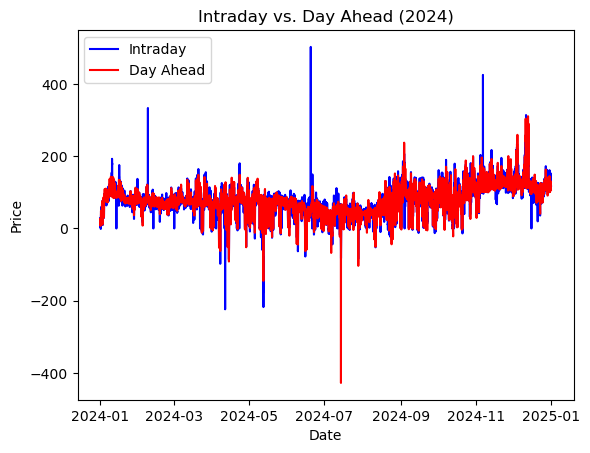

In [24]:
plt.plot(intraday_2024['date_ref'], intraday_2024['price'], label='Intraday', color='blue')
plt.plot(price_data_2024['Date (GMT+1)'], price_data_2024['Day Ahead Auction (CH)'], label='Day Ahead', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Intraday vs. Day Ahead (2024)')
plt.legend()
plt.show()